In [ ]:
# default_exp instance_segmentation.tutorial

# Tutorial

> The goal of this challenge is to find all instances of dolphins in a picture and then color pixes of each dolphin with a unique color.

In [ ]:
import numpy as np
import PIL
from PIL import Image

import torch
import torchvision
import pandas as pd
import seaborn as sns

## Download data

We start by downloading and visualizing the dataset containing 200 photographs with one or more dolphins split into a training set containing 160 photographs and a validation set containing 40 photographs.

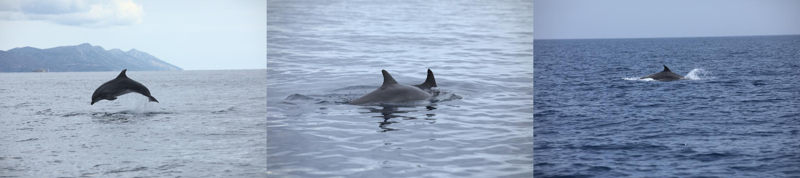

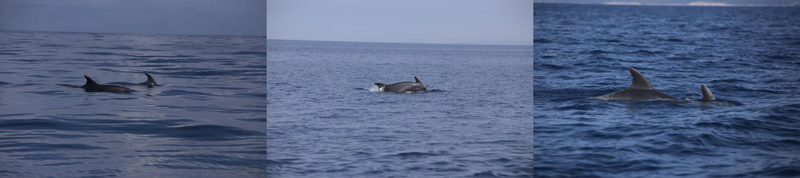

In [ ]:
from dolphins_recognition_challenge.datasets import get_dataset, display_batches
    
data_loader, data_loader_test = get_dataset("segmentation", batch_size=3)

display_batches(data_loader, n_batches=2)

## Data augmentation

In order to prevent overfitting which happens when the dataset size is too small, we perform a number of transformations to increase the size of the dataset. One transofrmation implemented in the Torch vision library is `RandomHorizontalFlip` and we will implemented `MyColorJitter` which is basically just a wrapper around `torchvision.transforms.ColorJitter` class. However, we cannot use this class directly without a wrapper because a transofrmation could possibly affect targets and not just the image. For example, if we were to implement RandomCrop, we would need to crop segmentation masks and readjust bounding boxes as well.

In [ ]:
class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target

We will make a series of transformations on an image and we will combine all those transofrmations in a single one as follows:

In [ ]:
from dolphins_recognition_challenge.datasets import ToTensor, ToPILImage, Compose, RandomHorizontalFlip

def get_tensor_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(
            MyColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        )
        transforms.append(RandomHorizontalFlip(0.5))
        # TODO: add additional transforms: e.g. random crop
    return Compose(transforms)

With data augementation defined, we are ready to generate the actual datasets used for training our models.

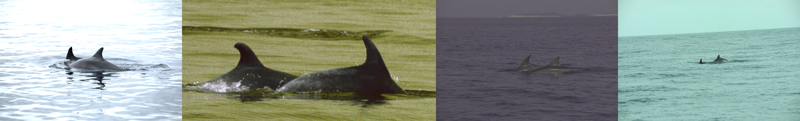

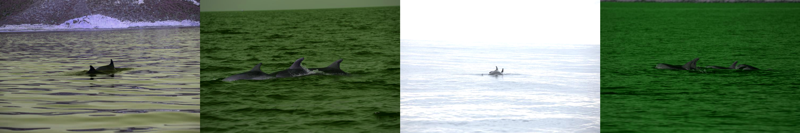

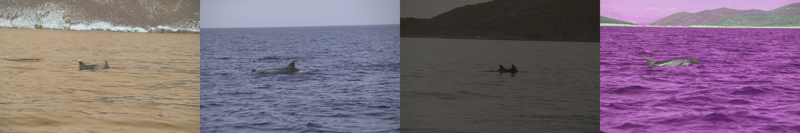

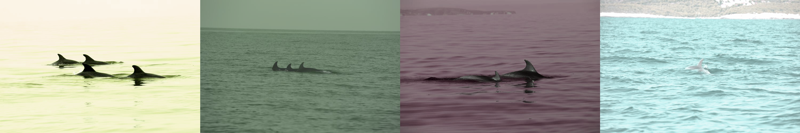

In [ ]:
batch_size = 4

data_loader, data_loader_test = get_dataset(
    "segmentation", get_tensor_transforms=get_tensor_transforms, batch_size=batch_size
)

display_batches(data_loader, n_batches=4)

> Tip: incorporate more transformation classes such as RandomCrop etc. (https://pytorch.org/docs/stable/torchvision/transforms.html)

## Model

We can reuse already trained models for instance segmentation trained on other dataset and finetune it for our particular problem, in our case on dataset with dolphins.

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(hidden_layer_size, box_score_thresh=0.5):
    # our dataset has two classes only - background and dolphin    
    num_classes = 2
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        box_score_thresh=box_score_thresh, 
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask, 
        dim_reduced=hidden_layer_size,
        num_classes=num_classes
    )

    return model

Before using a model constructed, we should move it to appropriate device. We will test if we have GPU available and move it to there if possible.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

We have implemented a function for training a model for one epoch - meaning using each image from the training dataset exactly once.

In [ ]:
#hide_output

from dolphins_recognition_challenge.instance_segmentation.model import train_one_epoch

# let's train it for 20 epochs
num_epochs = 20

print("Training...")

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)

    # update the learning rate
    lr_scheduler.step()

Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:00:47  lr: 0.000133  loss: 3.7051 (3.7051)  loss_classifier: 1.0402 (1.0402)  loss_box_reg: 0.2985 (0.2985)  loss_mask: 2.2961 (2.2961)  loss_objectness: 0.0239 (0.0239)  loss_rpn_box_reg: 0.0463 (0.0463)  time: 1.1824  data: 0.6804  max mem: 4476
Epoch: [0]  [20/40]  eta: 0:00:10  lr: 0.002695  loss: 0.9304 (1.4713)  loss_classifier: 0.2222 (0.3594)  loss_box_reg: 0.2591 (0.2790)  loss_mask: 0.4268 (0.7149)  loss_objectness: 0.0223 (0.0645)  loss_rpn_box_reg: 0.0181 (0.0536)  time: 0.4727  data: 0.0074  max mem: 4753
Epoch: [0]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.6051 (1.0601)  loss_classifier: 0.1110 (0.2406)  loss_box_reg: 0.1986 (0.2424)  loss_mask: 0.2532 (0.4948)  loss_objectness: 0.0130 (0.0422)  loss_rpn_box_reg: 0.0144 (0.0402)  time: 0.4740  data: 0.0078  max mem: 5183
Epoch: [0] Total time: 0:00:19 (0.4924 s / it)
Epoch: [1]  [ 0/40]  eta: 0:00:48  lr: 0.005000  loss: 0.5000 (0.5000)  loss_classifier: 0.0643 (0.0643)  loss_box_reg: 0.154

Epoch: [9]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.2800 (0.2869)  loss_classifier: 0.0361 (0.0400)  loss_box_reg: 0.0858 (0.0855)  loss_mask: 0.1319 (0.1370)  loss_objectness: 0.0025 (0.0054)  loss_rpn_box_reg: 0.0055 (0.0190)  time: 0.5319  data: 0.0078  max mem: 5185
Epoch: [9] Total time: 0:00:21 (0.5456 s / it)
Epoch: [10]  [ 0/40]  eta: 0:00:48  lr: 0.000500  loss: 0.1983 (0.1983)  loss_classifier: 0.0245 (0.0245)  loss_box_reg: 0.0614 (0.0614)  loss_mask: 0.1079 (0.1079)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.2073  data: 0.7138  max mem: 5185
Epoch: [10]  [20/40]  eta: 0:00:11  lr: 0.000500  loss: 0.2476 (0.2558)  loss_classifier: 0.0338 (0.0349)  loss_box_reg: 0.0659 (0.0769)  loss_mask: 0.1284 (0.1349)  loss_objectness: 0.0018 (0.0021)  loss_rpn_box_reg: 0.0055 (0.0069)  time: 0.5304  data: 0.0077  max mem: 5185
Epoch: [10]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2815 (0.2703)  loss_classifier: 0.0369 (0.0375)  loss_box_reg: 0.

Epoch: [19]  [ 0/40]  eta: 0:00:50  lr: 0.000500  loss: 0.2373 (0.2373)  loss_classifier: 0.0289 (0.0289)  loss_box_reg: 0.0430 (0.0430)  loss_mask: 0.1520 (0.1520)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0120 (0.0120)  time: 1.2670  data: 0.7736  max mem: 5185
Epoch: [19]  [20/40]  eta: 0:00:11  lr: 0.000500  loss: 0.2187 (0.2447)  loss_classifier: 0.0306 (0.0327)  loss_box_reg: 0.0526 (0.0630)  loss_mask: 0.1217 (0.1272)  loss_objectness: 0.0011 (0.0023)  loss_rpn_box_reg: 0.0041 (0.0195)  time: 0.5327  data: 0.0071  max mem: 5185
Epoch: [19]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2400 (0.2418)  loss_classifier: 0.0355 (0.0335)  loss_box_reg: 0.0779 (0.0671)  loss_mask: 0.1215 (0.1258)  loss_objectness: 0.0013 (0.0020)  loss_rpn_box_reg: 0.0040 (0.0134)  time: 0.5482  data: 0.0080  max mem: 5185
Epoch: [19] Total time: 0:00:22 (0.5600 s / it)


We can see the predictions made by a model using `show_predictions` function as folllows:

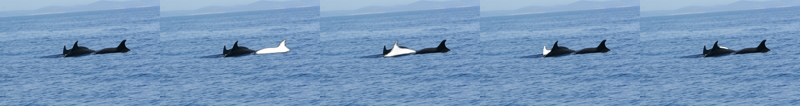

In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import show_predictions

show_predictions(model, data_loader=data_loader_test, n=1, score_limit=0.5)

## Calculate metrics

IOU metric is: 0.47780282470937807


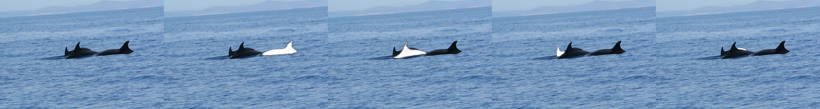

IOU metric is: 0.6377577838020212


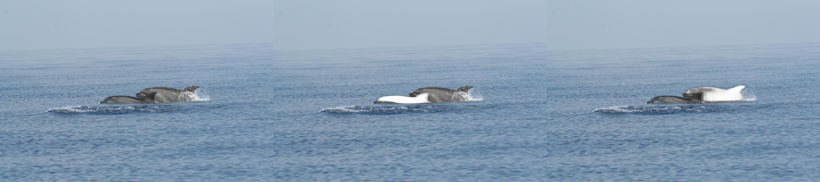

IOU metric is: 0.5237924539461893


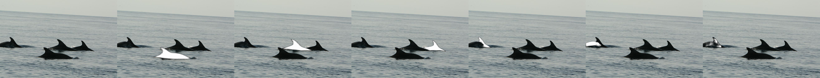

IOU metric is: 0.6395129682841751


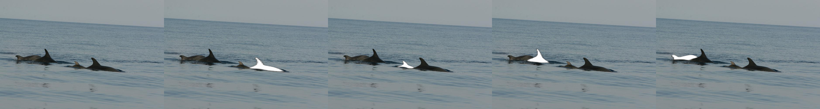

In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import show_prediction, get_true_and_predicted_masks, iou_metric

for i in range(4):
    _, masks = get_true_and_predicted_masks(model, data_loader_test.dataset[i], 0.5)
    iou = iou_metric(masks)
    img, _ = data_loader_test.dataset[i]
    print(f"IOU metric is: {iou}")
    show_prediction(model, img, width=820)
